> absrtact: run CHAR-CNN-LSTM BERT on test-1blm-prob.

# Setup

In [ ]:
# Need to download env or not
need_reload = True

# if False, Char-CNN-LSTM-BERT
CCLB = False

# Environment

## Set google drive

In [ ]:
# Load google drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g4jo4hZnINea0Zs-T8GmRy6AXKQzsXTWan0WSNk2LqXnC-LlzQK_e4
Mounted at /content/gdrive


## Set packages

In [ ]:
if need_reload:
    # Install neuspell
    !git clone https://github.com/neuspell/neuspell
    %cd neuspell
    !pip install -e .
    !pip install -r extras-requirements.txt

    # Show pip conflict
    !python -m pip check

    # Resolve pip conflict (only relevent ones)
    !pip install torch==1.7.1 transformers==4.2.2 torchvision==0.8.2 torchtext==0.8 urllib3==1.25.4

    # Show pip conflict, all solved
    !python -m pip check

    # Download datasets
    %cd data/traintest
    !python download_datafiles.py

    # Back to the original cd
    %cd ../../

Cloning into 'neuspell'...
remote: Enumerating objects: 653, done.
remote: Counting objects: 100% (456/456), done.
remote: Compressing objects: 100% (287/287), done.
remote: Total 653 (delta 280), reused 303 (delta 151), pack-reused 197
Receiving objects: 100% (653/653), 74.43 MiB | 36.66 MiB/s, done.
Resolving deltas: 100% (306/306), done.
/content/neuspell
Obtaining file:///content/neuspell
     |████████████████████████████████| 2.1MB 3.5MB/s 
     |████████████████████████████████| 1.2MB 21.9MB/s 
     |████████████████████████████████| 133kB 28.5MB/s 
     |████████████████████████████████| 3.3MB 27.5MB/s 
     |████████████████████████████████| 901kB 38.2MB/s 
     |████████████████████████████████| 133kB 39.2MB/s 
     |████████████████████████████████| 7.5MB 59.5MB/s 
     |████████████████████████████████| 81kB 12.0MB/s 
ERROR: botocore 1.20.64 has requirement urllib3<1.27,>=1.25.4, but you'll have urllib3 1.24.3 which is incompatible.
  Running setup.py develop for neuspell
O

# Library

In [ ]:
import os
import time

######################################################################
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import transformers
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence

######################################################################
import neuspell
from neuspell.commons import DEFAULT_TRAINTEST_DATA_PATH
from neuspell.seq_modeling.helpers import *
from neuspell.seq_modeling.evals import get_metrics

######################################################################
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

######################################################################
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

print(DEVICE)

# Build Model

In [ ]:
######################################################################

DEFAULT_BERT_PRETRAINED_NAME_OR_PATH = "bert-base-cased"

######################################################################


def get_pretrained_bert(pretrained_name_or_path=None):
    pretrained_name_or_path = (
        pretrained_name_or_path or DEFAULT_BERT_PRETRAINED_NAME_OR_PATH
    )
    return transformers.AutoModel.from_pretrained(pretrained_name_or_path)


######################################################################


class CharCNNModel(nn.Module):
    def __init__(self, nembs, embdim, padding_idx, filterlens, nfilters):
        super(CharCNNModel, self).__init__()

        # Embeddings
        self.embeddings = nn.Embedding(nembs, embdim, padding_idx=padding_idx)
        # torch.nn.init.normal_(self.embeddings.weight.data, std=1.0)
        self.embeddings.weight.requires_grad = True

        # Unsqueeze [BS, MAXSEQ, EMDDIM] as [BS, 1, MAXSEQ, EMDDIM] and send as input
        self.convmodule = nn.ModuleList()
        for length, n in zip(filterlens, nfilters):
            self.convmodule.append(
                nn.Sequential(
                    nn.Conv2d(
                        1,
                        n,
                        (length, embdim),
                        padding=(length - 1, 0),
                        dilation=1,
                        bias=True,
                        padding_mode="zeros",
                    ),
                    nn.ReLU(),
                )
            )
        # each conv outputs [BS, nfilters, MAXSEQ, 1]

    def forward(self, batch_tensor):
        batch_size = len(batch_tensor)

        # [BS, max_seq_len]->[BS, max_seq_len, emb_dim]
        embs = self.embeddings(batch_tensor)

        # [BS, max_seq_len, emb_dim]->[BS, 1, max_seq_len, emb_dim]
        embs_unsqueezed = torch.unsqueeze(embs, dim=1)

        # [BS, 1, max_seq_len, emb_dim]->[BS, out_channels, max_seq_len, 1]->[BS, out_channels, max_seq_len]
        conv_outputs = [conv(embs_unsqueezed).squeeze(3) for conv in self.convmodule]

        # [BS, out_channels, max_seq_len]->[BS, out_channels]
        maxpool_conv_outputs = [
            F.max_pool1d(out, out.size(2)).squeeze(2) for out in conv_outputs
        ]

        # cat( [BS, out_channels] )->[BS, sum(nfilters)]
        source_encodings = torch.cat(maxpool_conv_outputs, dim=1)
        return source_encodings


######################################################################


class BERTCharCNNWordLSTM(nn.Module):
    def __init__(
        self,
        nchars,
        char_emb_dim,
        char_padding_idx,
        screp_dim,
        padding_idx,
        output_dim,
        early_concat=False,
        bert_pretrained_name_or_path=None,
        freeze_bert=False,
    ):
        super(BERTCharCNNWordLSTM, self).__init__()

        self.bert_dropout = torch.nn.Dropout(0.2)
        self.bert_model = get_pretrained_bert(bert_pretrained_name_or_path)
        self.bertmodule_outdim = self.bert_model.config.hidden_size
        # if True, (bert+sc)->lstm->linear, else ((sc->lstm)+bert)->linear
        self.early_concat = early_concat

        if freeze_bert:
            # Uncomment to freeze BERT layers
            for param in self.bert_model.parameters():
                param.requires_grad = False

        # cnn module
        # takes in a list[pad_sequence] with each pad_sequence of dim: [BS][nwords,max_nchars]
        # runs a for loop to obtain list[tensor] with each tensor of dim: [BS][nwords,sum(nfilters)]
        # then use rnn.pad_sequence(.) to obtain the dim: [BS, max_nwords, sum(nfilters)]
        nfilters, filtersizes = [50, 100, 100, 100], [2, 3, 4, 5]
        self.cnnmodule = CharCNNModel(
            nchars, char_emb_dim, char_padding_idx, filtersizes, nfilters
        )
        self.cnnmodule_outdim = sum(nfilters)

        # lstm module
        # expected  input dim: [BS,max_nwords,*] and batch_lengths as [BS] for pack_padded_sequence
        bidirectional, hidden_size, nlayers = True, 512, 2
        if self.early_concat:
            self.lstmmodule_indim = self.cnnmodule_outdim + self.bertmodule_outdim
            self.lstmmodule = nn.LSTM(
                self.lstmmodule_indim,
                hidden_size,
                nlayers,
                batch_first=True,
                dropout=0.3,
                bidirectional=bidirectional,
            )
            self.lstmmodule_outdim = hidden_size * 2 if bidirectional else hidden_size
            self.encodings_outdim = self.lstmmodule_outdim
        else:
            self.lstmmodule_indim = self.cnnmodule_outdim
            self.lstmmodule = nn.LSTM(
                self.lstmmodule_indim,
                hidden_size,
                nlayers,
                batch_first=True,
                dropout=0.3,
                bidirectional=bidirectional,
            )
            self.lstmmodule_outdim = hidden_size * 2 if bidirectional else hidden_size
            self.encodings_outdim = self.lstmmodule_outdim + self.bertmodule_outdim

        # output module
        assert output_dim > 0
        self.dropout = nn.Dropout(p=0.4)
        self.dense = nn.Linear(self.encodings_outdim, output_dim)

        # loss
        # See https://pytorch.org/docs/stable/nn.html#crossentropyloss
        self.criterion = nn.CrossEntropyLoss(reduction="mean", ignore_index=padding_idx)

    @property
    def device(self) -> torch.device:
        return next(self.parameters()).device

    def get_merged_encodings(self, bert_seq_encodings, seq_splits, mode="avg"):
        bert_seq_encodings = bert_seq_encodings[
            : sum(seq_splits) + 2, :
        ]  # 2 for [CLS] and [SEP]
        bert_seq_encodings = bert_seq_encodings[1:-1, :]
        # a tuple of tensors
        split_encoding = torch.split(bert_seq_encodings, seq_splits, dim=0)
        batched_encodings = pad_sequence(
            split_encoding, batch_first=True, padding_value=0
        )
        if mode == "avg":
            seq_splits = torch.tensor(seq_splits).reshape(-1, 1).to(self.device)
            out = torch.div(torch.sum(batched_encodings, dim=1), seq_splits)
        elif mode == "add":
            out = torch.sum(batched_encodings, dim=1)
        else:
            raise Exception("Not Implemented")
        return out

    def forward(
        self,
        batch_screps: "list[pad_sequence]",
        batch_lengths: "tensor",
        batch_bert_dict: "{'input_ids':tensor, 'attention_mask':tensor, 'token_type_ids':tensor}",
        batch_splits: "list[list[int]]",
        aux_word_embs: "tensor" = None,
        targets: "tensor" = None,
        topk=1,
    ):

        if aux_word_embs is not None:
            raise Exception("dimensions of aux_word_embs not used in __init__()")

        # cnn
        batch_size = len(batch_screps)

        cnn_encodings = [
            self.cnnmodule(pad_sequence_) for pad_sequence_ in batch_screps
        ]
        cnn_encodings = pad_sequence(cnn_encodings, batch_first=True, padding_value=0)

        # bert
        # BS X max_nsubwords x self.bertmodule_outdim
        bert_encodings = self.bert_model(**batch_bert_dict, return_dict=False)[0]
        bert_encodings = self.bert_dropout(bert_encodings)
        # BS X max_nwords x self.bertmodule_outdim
        bert_merged_encodings = pad_sequence(
            [
                self.get_merged_encodings(bert_seq_encodings, seq_splits, mode="avg")
                for bert_seq_encodings, seq_splits in zip(bert_encodings, batch_splits)
            ],
            batch_first=True,
            padding_value=0,
        )

        # if True, (bert+sc)->lstm->linear, else ((sc->lstm)+bert)->linear
        # We go with "else" first
        if self.early_concat:

            # concat aux_embs
            # if not None, the expected dim for aux_word_embs: [BS,max_nwords,*]
            intermediate_encodings = torch.cat(
                (cnn_encodings, bert_merged_encodings), dim=2
            )
            if aux_word_embs is not None:
                intermediate_encodings = torch.cat(
                    (intermediate_encodings, aux_word_embs), dim=2
                )

            # lstm
            # dim: [BS,max_nwords,*]->[BS,max_nwords,self.lstmmodule_outdim]
            intermediate_encodings = pack_padded_sequence(
                intermediate_encodings,
                batch_lengths,
                batch_first=True,
                enforce_sorted=False,
            )
            lstm_encodings, (last_hidden_states, last_cell_states) = self.lstmmodule(
                intermediate_encodings
            )
            lstm_encodings, _ = pad_packed_sequence(
                lstm_encodings, batch_first=True, padding_value=0
            )

            # out
            final_encodings = lstm_encodings

        else:

            # concat aux_embs
            # if not None, the expected dim for aux_word_embs: [BS,max_nwords,*]
            intermediate_encodings = cnn_encodings
            if aux_word_embs is not None:
                intermediate_encodings = torch.cat(
                    (intermediate_encodings, aux_word_embs), dim=2
                )

                # lstm
            # dim: [BS,max_nwords,*]->[BS,max_nwords,self.lstmmodule_outdim]
            intermediate_encodings = pack_padded_sequence(
                intermediate_encodings,
                batch_lengths,
                batch_first=True,
                enforce_sorted=False,
            )
            lstm_encodings, (last_hidden_states, last_cell_states) = self.lstmmodule(
                intermediate_encodings
            )
            lstm_encodings, _ = pad_packed_sequence(
                lstm_encodings, batch_first=True, padding_value=0
            )

            # out
            final_encodings = torch.cat((lstm_encodings, bert_merged_encodings), dim=2)

        # dense
        # [BS,max_nwords,self.encodings_outdim]->[BS,max_nwords,output_dim]
        logits = self.dense(self.dropout(final_encodings))

        # loss
        if targets is not None:
            assert len(targets) == batch_size  # targets:[[BS,max_nwords]
            # logits: [BS,output_dim,max_nwords]
            logits_permuted = logits.permute(0, 2, 1)
            loss = self.criterion(logits_permuted, targets)

        # eval preds
        if not self.training:
            probs = F.softmax(logits, dim=-1)  # [BS,max_nwords,output_dim]
            if topk > 1:
                topk_values, topk_inds = torch.topk(
                    probs, topk, dim=-1, largest=True, sorted=True
                )  # -> (Tensor, LongTensor) of [BS,max_nwords,topk]
            elif topk == 1:
                topk_inds = torch.argmax(probs, dim=-1)  # [BS,max_nwords]

            # Note that for those positions with padded_idx,
            #   the arg_max_prob above computes a index because
            #   the bias term leads to non-uniform values in those positions

            return loss.cpu().detach().numpy(), topk_inds.cpu().detach().numpy()
        return loss

In [ ]:
def load_model(vocab, verbose=False, early_concat=False):
    CHAR_EMBS_DIM = 100
    model = BERTCharCNNWordLSTM(
        len(vocab["chartoken2idx"]),
        CHAR_EMBS_DIM,
        vocab["chartoken2idx"][vocab["char_pad_token"]],
        3 * len(vocab["chartoken2idx"]),
        vocab["token2idx"][vocab["pad_token"]],
        len(vocab["token_freq"]),
        early_concat=early_concat,
    )

    if verbose:
        print(model)
    print(f"Number of parameters in the model: {get_model_nparams(model)}")

    return model

In [ ]:
def model_inference(model, data, topk, device, batch_size=16, vocab_=None):
    """
    model: an instance of BertSCLSTM
    data: list of tuples, with each tuple consisting of correct and incorrect 
            sentence string (would be split at whitespaces)
    topk: how many of the topk softmax predictions are considered for metrics calculations
    """
    if vocab_ is not None:
        vocab = vocab_
    print("###############################################")
    inference_st_time = time.time()
    _corr2corr, _corr2incorr, _incorr2corr, _incorr2incorr = 0, 0, 0, 0
    _mistakes = []
    VALID_batch_size = batch_size
    valid_loss = 0.0
    valid_acc = 0.0
    print("data size: {}".format(len(data)))
    data_iter = batch_iter(data, batch_size=VALID_batch_size, shuffle=False)
    model.eval()
    model.to(device)
    for batch_id, (batch_labels, batch_sentences) in tqdm(enumerate(data_iter)):
        torch.cuda.empty_cache()
        st_time = time.time()
        # set batch data for bert
        (
            batch_labels_,
            batch_sentences_,
            batch_bert_inp,
            batch_bert_splits,
        ) = bert_tokenize_for_valid_examples(batch_labels, batch_sentences)
        if len(batch_labels_) == 0:
            print("################")
            print(
                "Not predicting the following lines due to pre-processing mismatch: \n"
            )
            print([(a, b) for a, b in zip(batch_labels, batch_sentences)])
            print("################")
            continue
        else:
            batch_labels, batch_sentences = batch_labels_, batch_sentences_
        batch_bert_inp = {k: v.to(device) for k, v in batch_bert_inp.items()}
        # set batch data for others
        batch_labels_ids, batch_lengths = labelize(batch_labels, vocab)
        batch_idxs, batch_lengths_ = char_tokenize(batch_sentences, vocab)
        assert (batch_lengths_ == batch_lengths).all() == True
        assert len(batch_bert_splits) == len(batch_idxs)
        batch_idxs = [batch_idxs_.to(device) for batch_idxs_ in batch_idxs]
        # batch_lengths = batch_lengths.to(device)
        batch_labels_ids = batch_labels_ids.to(device)
        # forward
        try:
            with torch.no_grad():
                """
                NEW: batch_predictions can now be of shape (batch_size,batch_max_seq_len,topk) if topk>1, else (batch_size,batch_max_seq_len)
                """
                batch_loss, batch_predictions = model(
                    batch_idxs,
                    batch_lengths,
                    batch_bert_inp,
                    batch_bert_splits,
                    targets=batch_labels_ids,
                    topk=topk,
                )
        except RuntimeError:
            print(
                f"batch_idxs:{len(batch_idxs)},batch_lengths:{batch_lengths.shape},batch_bert_inp:{len(batch_bert_inp.keys())},batch_labels_ids:{batch_labels_ids.shape}"
            )
            raise Exception("")
        valid_loss += batch_loss
        # compute accuracy in numpy
        batch_labels_ids = batch_labels_ids.cpu().detach().numpy()
        batch_lengths = batch_lengths.cpu().detach().numpy()
        # based on topk, obtain either strings of batch_predictions or list of tokens
        if topk == 1:
            batch_predictions = untokenize_without_unks(
                batch_predictions, batch_lengths, vocab, batch_sentences
            )
        else:
            batch_predictions = untokenize_without_unks2(
                batch_predictions, batch_lengths, vocab, batch_sentences, topk=None
            )
        # corr2corr, corr2incorr, incorr2corr, incorr2incorr, mistakes = \
        #    get_metrics(batch_labels,batch_sentences,batch_predictions,check_until_topk=topk,return_mistakes=True)
        # _mistakes.extend(mistakes)
        # batch_labels = [line.lower() for line in batch_labels]
        # batch_sentences = [line.lower() for line in batch_sentences]
        # batch_predictions = [line.lower() for line in batch_predictions]
        corr2corr, corr2incorr, incorr2corr, incorr2incorr = get_metrics(
            batch_labels,
            batch_sentences,
            batch_predictions,
            check_until_topk=topk,
            return_mistakes=False,
        )
        _corr2corr += corr2corr
        _corr2incorr += corr2incorr
        _incorr2corr += incorr2corr
        _incorr2incorr += incorr2incorr

        # delete
        del batch_loss
        del batch_predictions
        del batch_labels, batch_lengths, batch_idxs, batch_lengths_, batch_bert_inp
        torch.cuda.empty_cache()

        """
        # update progress
        progressBar(batch_id+1,
                    int(np.ceil(len(data) / VALID_batch_size)), 
                    ["batch_time","batch_loss","avg_batch_loss","batch_acc","avg_batch_acc"], 
                    [time.time()-st_time,batch_loss,valid_loss/(batch_id+1),None,None])
        """
    print(f"\nEpoch {None} valid_loss: {valid_loss / (batch_id + 1)}")
    print(
        "total inference time for this data is: {:4f} secs".format(
            time.time() - inference_st_time
        )
    )
    print("###############################################")
    print("")
    # for mistake in _mistakes:
    #    print(mistake)
    print("")
    print(
        "total token count: {}".format(
            _corr2corr + _corr2incorr + _incorr2corr + _incorr2incorr
        )
    )
    print(
        f"_corr2corr:{_corr2corr}, _corr2incorr:{_corr2incorr}, _incorr2corr:{_incorr2corr}, _incorr2incorr:{_incorr2incorr}"
    )
    print(
        f"accuracy is {(_corr2corr + _incorr2corr) / (_corr2corr + _corr2incorr + _incorr2corr + _incorr2incorr)}"
    )
    print(f"word correction rate is {(_incorr2corr) / (_incorr2corr + _incorr2incorr)}")
    print("###############################################")
    return

# Re-train Model

## Step-0: Set PATH

In [ ]:
TRAIN_TEST_FILE_PATH = DEFAULT_TRAINTEST_DATA_PATH
PATH = "/content/gdrive/MyDrive/Colab Notebooks/NLP_Project/Yuan/Exp3.1 catbert/Model/cnnlstmbert.pt"

## Step-1: Load train and test files, create a validation split

In [ ]:
clean_file = "test.1blm"
corrupt_file = "test.1blm.noise.prob"

train_data = load_data(TRAIN_TEST_FILE_PATH, clean_file, corrupt_file)
train_data, valid_data = train_validation_split(train_data, 0.9, seed=1)
print(len(train_data), len(valid_data))

273134it [00:00, 366217.60it/s]
273134it [00:00, 1401885.77it/s]


loaded tuples of (corr,incorr) examples from /content/neuspell/neuspell/../data/traintest
245821 27313


## Step-2: Create vocab file.

In [ ]:
# Create vocab from train_data
vocab_ref = {}
vocab = get_tokens(
    [i[0] for i in train_data],
    keep_simple=True,
    min_max_freq=(2, float("inf")),
    topk=100000,
    intersect=vocab_ref,
    load_char_tokens=True,
)

# See how many UNK labels in token
print(num_unk_tokens([i[0] for i in train_data], vocab))
print(num_unk_tokens([i[0] for i in valid_data], vocab))
print("")
print([*vocab.keys()])

100%|██████████| 245821/245821 [00:01<00:00, 159472.24it/s]


Total tokens found: 155272


  0%|          | 0/245821 [00:00<?, ?it/s]

Total tokens retained: 139243
Total tokens retained: 67965
Total tokens retained: 67965
loading character tokens


  6%|▋         | 15758/245821 [00:00<00:01, 157579.40it/s]

number of unique chars found: 98
{'<<CHAR_UNK>>': 0, '<<CHAR_PAD>>': 1, '<<CHAR_START>>': 2, '<<CHAR_END>>': 3, 'H': 4, 'e': 5, ' ': 6, 'w': 7, 'a': 8, 's': 9, 'b': 10, 'r': 11, 'i': 12, 'f': 13, 'l': 14, 'y': 15, 'h': 16, 'o': 17, 'p': 18, 't': 19, 'z': 20, 'd': 21, 'n': 22, 'c': 23, 'k': 24, 'j': 25, 'u': 26, '.': 27, 'A': 28, 'm': 29, 'B': 30, 'g': 31, 'G': 32, 'M': 33, '3': 34, 'v': 35, ',': 36, '7': 37, '6': 38, '2': 39, 'T': 40, 'D': 41, 'S': 42, 'E': 43, '1': 44, '-': 45, 'x': 46, '4': 47, '9': 48, '(': 49, 'U': 50, 'P': 51, 'I': 52, ')': 53, "'": 54, ';': 55, 'q': 56, '"': 57, '?': 58, 'Y': 59, 'C': 60, 'O': 61, 'K': 62, 'L': 63, 'N': 64, 'R': 65, 'W': 66, '0': 67, '8': 68, 'J': 69, ':': 70, 'F': 71, '5': 72, '%': 73, 'V': 74, '/': 75, '$': 76, 'Z': 77, 'Q': 78, '!': 79, '[': 80, ']': 81, 'X': 82, '&': 83, '@': 84, '+': 85, '_': 86, '#': 87, '*': 88, '|': 89, '>': 90, '^': 91, '\\': 92, '=': 93, '<': 94, '~': 95, '{': 96, '}': 97}


100%|██████████| 27313/27313 [00:00<00:00, 151030.86it/s]

#unk-tokenizations: 176452/5473213, %unk-tokenizations: 3.2239
None
#unk-tokenizations: 23866/611891, %unk-tokenizations: 3.9004
None

['token2idx', 'idx2token', 'token_freq', 'pad_token', 'unk_token', 'eos_token', 'pad_token_idx', 'unk_token_idx', 'eos_token_idx', 'chartoken2idx', 'idx2chartoken', 'char_unk_token', 'char_pad_token', 'char_start_token', 'char_end_token', 'char_unk_token_idx', 'char_pad_token_idx', 'char_start_token_idx', 'char_end_token_idx']


## Step-3: Model parameters

In [ ]:
# Load model
model = load_model(vocab, verbose=False, early_concat=CCLB)

# Epochs and batch size
START_EPOCH, N_EPOCHS = 1, 10
TRAIN_BATCH_SIZE, VALID_BATCH_SIZE = 32, 32

# running stats
max_dev_acc, argmax_dev_acc = -1, -1
patience = 100

# Create an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# RE-define DEVIDE as codes below does not compromise CUDA:0
# DEVICE = "cpu"

# model to device
model.to(DEVICE)


Number of parameters in the model: 240155638


BERTCharCNNWordLSTM(
  (bert_dropout): Dropout(p=0.2, inplace=False)
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (Laye

## Step-4 Training and validation

In epoch: 1
train_data size: 245821



Percent: [----------------------------->] 100% || batch_time: 0.4722 || batch_loss: 0.5981 || avg_batch_loss: 1.3802 || batch_acc: 0.9292 || avg_batch_acc: 0.7789 
Epoch 1 train_loss: 1.380247993290471
valid_data size: 27313
Percent: [----------------------------->] 100% || batch_time: 0.1255 || batch_loss: 0.4584 || avg_batch_loss: 0.5242 || batch_acc: 0.9431 || avg_batch_acc: 0.9267 
Epoch 1 valid_loss: 0.5241837246775348
In epoch: 2
train_data size: 245821
Percent: [----------------------------->] 100% || batch_time: 0.4497 || batch_loss: 0.3389 || avg_batch_loss: 0.4587 || batch_acc: 0.9540 || avg_batch_acc: 0.9487 
Epoch 2 train_loss: 0.4586748507895125
valid_data size: 27313
Percent: [----------------------------->] 100% || batch_time: 0.1228 || batch_loss: 0.2664 || avg_batch_loss: 0.3075 || batch_acc: 0.9567 || avg_batch_acc: 0.9495 
Epoch 2 valid_loss: 0.3074640521225661


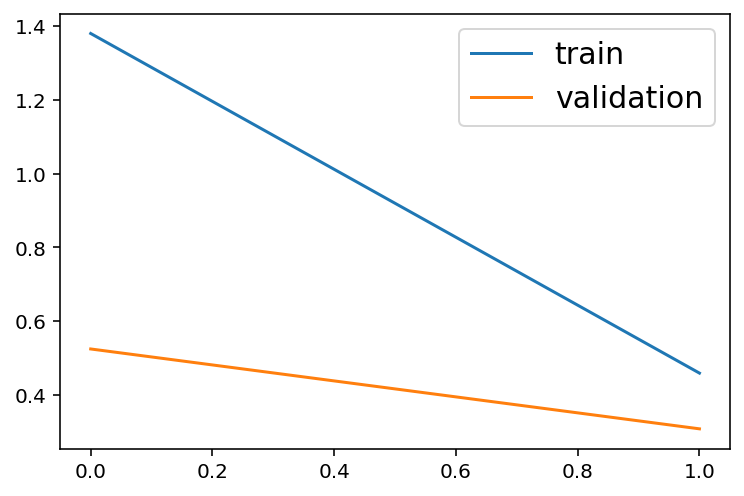

In epoch: 3
train_data size: 245821
Percent: [----------------------------->] 100% || batch_time: 0.4926 || batch_loss: 0.2462 || avg_batch_loss: 0.2817 || batch_acc: 0.9683 || avg_batch_acc: 0.9689 
Epoch 3 train_loss: 0.2816978443071607
valid_data size: 27313
Percent: [----------------------------->] 100% || batch_time: 0.1236 || batch_loss: 0.2279 || avg_batch_loss: 0.2382 || batch_acc: 0.9658 || avg_batch_acc: 0.9573 
Epoch 3 valid_loss: 0.2381880727337032


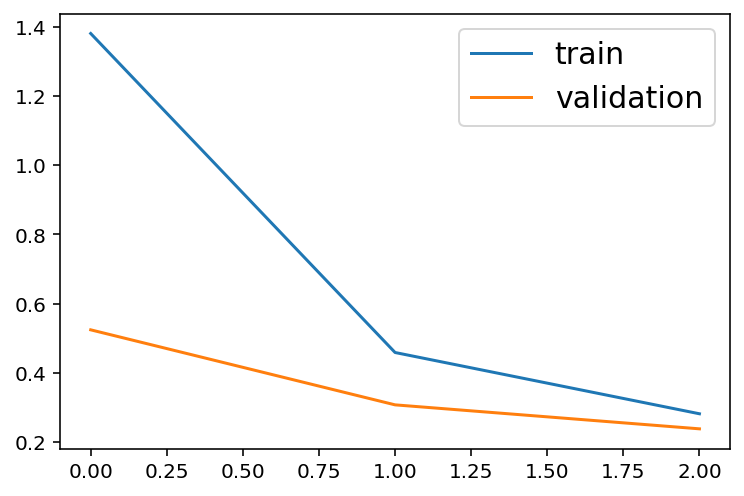

In epoch: 4
train_data size: 245821
Percent: [----------------------------->] 100% || batch_time: 0.4689 || batch_loss: 0.2899 || avg_batch_loss: 0.1965 || batch_acc: 0.9668 || avg_batch_acc: 0.9759 
Epoch 4 train_loss: 0.1965430963195742
valid_data size: 27313
Percent: [----------------------------->] 100% || batch_time: 0.1232 || batch_loss: 0.1582 || avg_batch_loss: 0.2028 || batch_acc: 0.9681 || avg_batch_acc: 0.9616 
Epoch 4 valid_loss: 0.2027931760132871


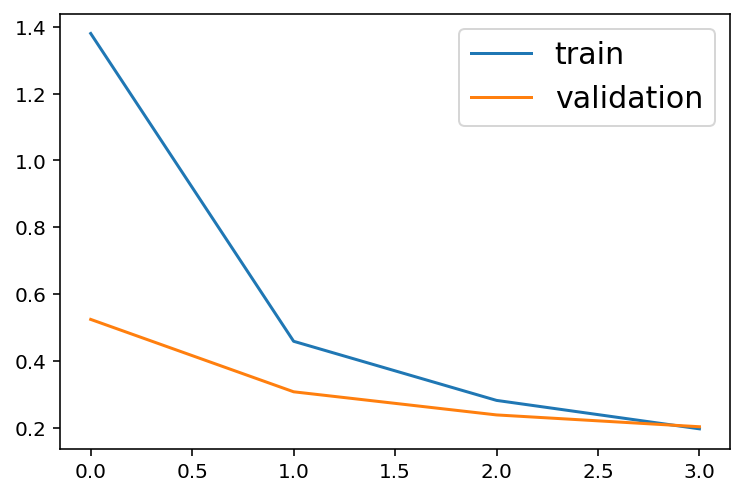

In epoch: 5
train_data size: 245821
Percent: [----------------------------->] 100% || batch_time: 0.5376 || batch_loss: 0.1926 || avg_batch_loss: 0.1465 || batch_acc: 0.9901 || avg_batch_acc: 0.9853 
Epoch 5 train_loss: 0.14649037122134817
valid_data size: 27313
Percent: [----------------------------->] 100% || batch_time: 0.1240 || batch_loss: 0.1472 || avg_batch_loss: 0.1863 || batch_acc: 0.9749 || avg_batch_acc: 0.9641 
Epoch 5 valid_loss: 0.18629404279540795


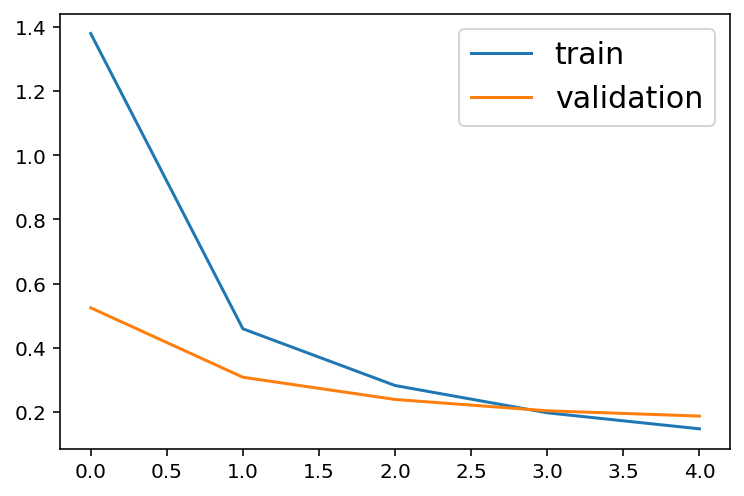

In epoch: 6
train_data size: 245821
Percent: [----------------------------->] 100% || batch_time: 0.4891 || batch_loss: 0.1591 || avg_batch_loss: 0.1125 || batch_acc: 0.9958 || avg_batch_acc: 0.9905 
Epoch 6 train_loss: 0.11250943094259189
valid_data size: 27313
Percent: [----------------------------->] 100% || batch_time: 0.1247 || batch_loss: 0.1636 || avg_batch_loss: 0.1789 || batch_acc: 0.9749 || avg_batch_acc: 0.9658 
Epoch 6 valid_loss: 0.17892243213236192


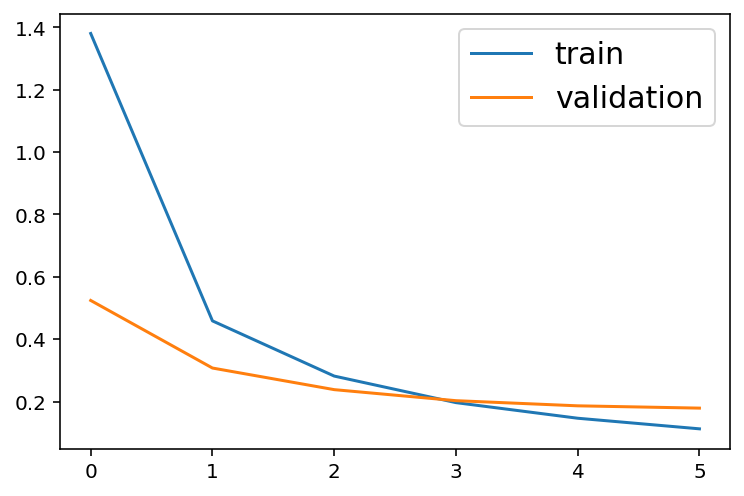

In epoch: 7
train_data size: 245821
Percent: [----------------------------->] 100% || batch_time: 0.4627 || batch_loss: 0.1346 || avg_batch_loss: 0.0911 || batch_acc: 0.9933 || avg_batch_acc: 0.9933 
Epoch 7 train_loss: 0.0911105509626271
valid_data size: 27313
Percent: [----------------------------->] 100% || batch_time: 0.1326 || batch_loss: 0.1805 || avg_batch_loss: 0.1839 || batch_acc: 0.9727 || avg_batch_acc: 0.9653 
Epoch 7 valid_loss: 0.18391115562139684


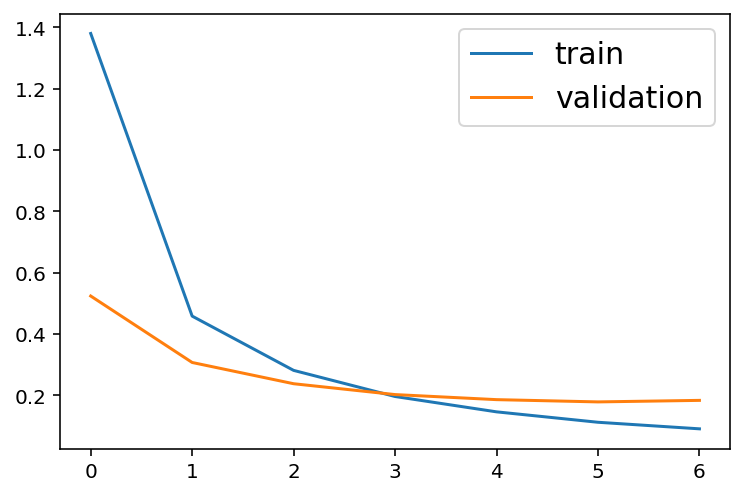

In epoch: 8
train_data size: 245821
Percent: [----------------------------->] 100% || batch_time: 0.4573 || batch_loss: 0.0750 || avg_batch_loss: 0.0759 || batch_acc: 0.9895 || avg_batch_acc: 0.9949 
Epoch 8 train_loss: 0.07590185589234877
valid_data size: 27313
Percent: [----------------------------->] 100% || batch_time: 0.1251 || batch_loss: 0.1821 || avg_batch_loss: 0.1762 || batch_acc: 0.9749 || avg_batch_acc: 0.9674 
Epoch 8 valid_loss: 0.1762281399159158


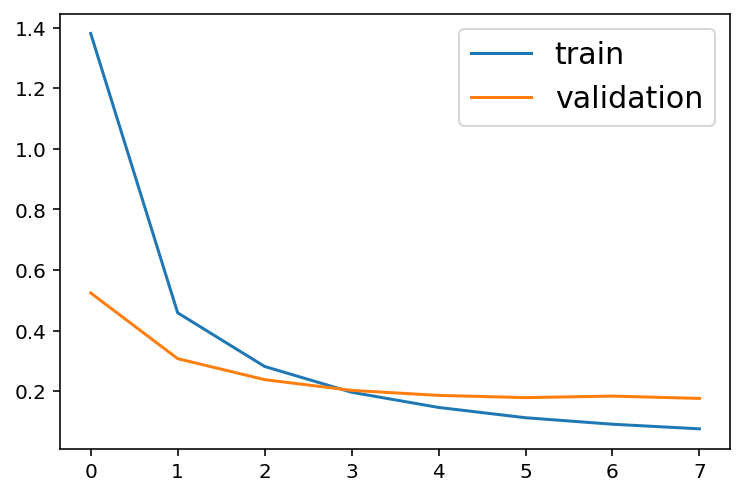

In epoch: 9
train_data size: 245821
Percent: [----------------------------->] 100% || batch_time: 0.4971 || batch_loss: 0.0804 || avg_batch_loss: 0.0679 || batch_acc: 0.9910 || avg_batch_acc: 0.9949 
Epoch 9 train_loss: 0.06787327070306115
valid_data size: 27313
Percent: [----------------------------->] 100% || batch_time: 0.1247 || batch_loss: 0.1361 || avg_batch_loss: 0.1758 || batch_acc: 0.9795 || avg_batch_acc: 0.9674 
Epoch 9 valid_loss: 0.1757832865909056


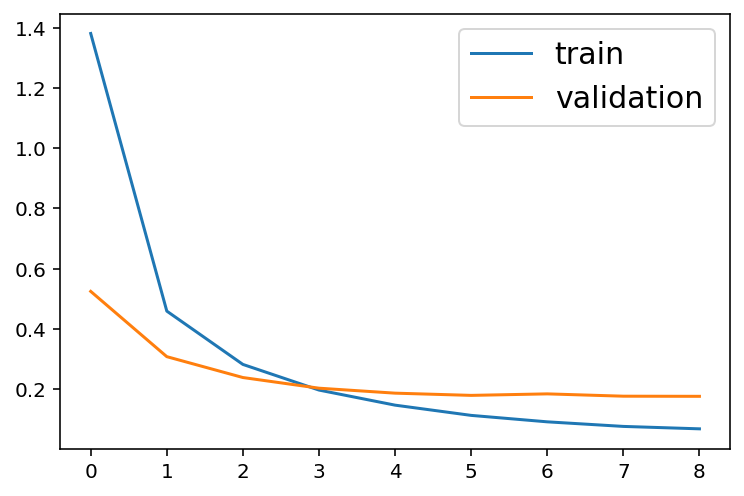

In epoch: 10
train_data size: 245821
Percent: [----------------------------->] 100% || batch_time: 0.5130 || batch_loss: 0.0700 || avg_batch_loss: 0.0599 || batch_acc: 0.9959 || avg_batch_acc: 0.9968 
Epoch 10 train_loss: 0.05990266025736075
valid_data size: 27313
Percent: [----------------------------->] 100% || batch_time: 0.1296 || batch_loss: 0.1718 || avg_batch_loss: 0.1789 || batch_acc: 0.9658 || avg_batch_acc: 0.9676 
Epoch 10 valid_loss: 0.178896036740628


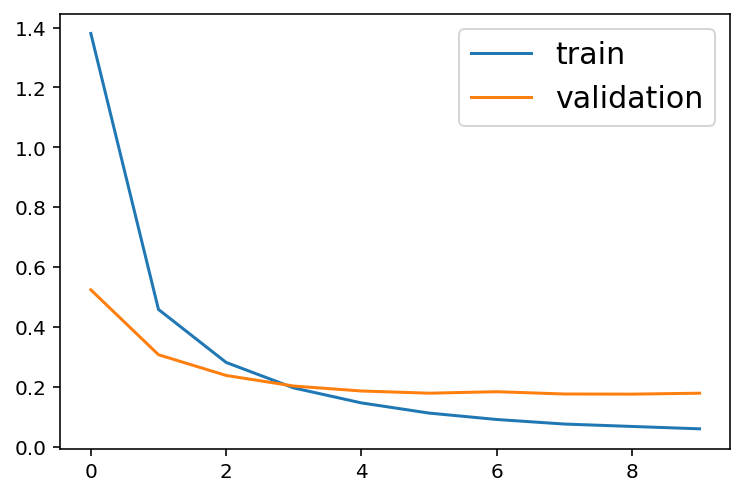

In [12]:
total_train_loss = []
total_val_loss = []

for epoch_id in range(1, N_EPOCHS + 1):
    if (epoch_id - argmax_dev_acc) > patience:
        print("patience count reached. early stopping initiated")
        print("max_dev_acc: {}, argmax_dev_acc: {}".format(max_dev_acc, argmax_dev_acc))
        break
    # print epoch
    print(f"In epoch: {epoch_id}")
    # train loss and backprop
    train_loss = 0.0
    train_acc = 0.0
    train_acc_count = 0.0
    print("train_data size: {}".format(len(train_data)))

    ##################TRAIN##################
    train_data_iter = batch_iter(train_data, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
    nbatches = int(np.ceil(len(train_data) / TRAIN_BATCH_SIZE))
    # for batch_id, (batch_labels,batch_sentences) in tqdm(enumerate(train_data_iter)):
    for batch_id, (batch_labels, batch_sentences) in enumerate(train_data_iter):
        optimizer.zero_grad()
        st_time = time.time()
        # set batch data for bert
        (
            batch_labels_,
            batch_sentences_,
            batch_bert_inp,
            batch_bert_splits,
        ) = bert_tokenize_for_valid_examples(batch_labels, batch_sentences)
        if len(batch_labels_) == 0:
            print("################")
            print("Not training the following lines due to pre-processing mismatch: \n")
            print([(a, b) for a, b in zip(batch_labels, batch_sentences)])
            print("################")
            continue
        else:
            batch_labels, batch_sentences = batch_labels_, batch_sentences_

        batch_bert_inp = {k: v.to(DEVICE) for k, v in batch_bert_inp.items()}

        # set batch data for others
        batch_labels, batch_lengths = labelize(batch_labels, vocab)
        batch_idxs, batch_lengths_ = char_tokenize(batch_sentences, vocab)
        assert (batch_lengths_ == batch_lengths).all() == True
        batch_idxs = [batch_idxs_.to(DEVICE) for batch_idxs_ in batch_idxs]
        # batch_lengths = batch_lengths.to(DEVICE)
        batch_labels = batch_labels.to(DEVICE)
        # forward
        model.train()
        loss = model(
            batch_idxs,
            batch_lengths,
            batch_bert_inp,
            batch_bert_splits,
            targets=batch_labels,
        )
        batch_loss = loss.cpu().detach().numpy()
        train_loss += batch_loss
        # backward
        loss.backward()
        optimizer.step()
        # compute accuracy in numpy
        if batch_id % 1000 == 0:
            train_acc_count += 1
            model.eval()
            with torch.no_grad():
                _, batch_predictions = model(
                    batch_idxs,
                    batch_lengths,
                    batch_bert_inp,
                    batch_bert_splits,
                    targets=batch_labels,
                )
            model.train()
            batch_labels = batch_labels.cpu().detach().numpy()
            batch_lengths = batch_lengths.cpu().detach().numpy()
            ncorr, ntotal = batch_accuracy_func(
                batch_predictions, batch_labels, batch_lengths
            )
            batch_acc = ncorr / ntotal
            train_acc += batch_acc
        # update progress
        progressBar(
            batch_id + 1,
            int(np.ceil(len(train_data) / TRAIN_BATCH_SIZE)),
            [
                "batch_time",
                "batch_loss",
                "avg_batch_loss",
                "batch_acc",
                "avg_batch_acc",
            ],
            [
                time.time() - st_time,
                batch_loss,
                train_loss / (batch_id + 1),
                batch_acc,
                train_acc / train_acc_count,
            ],
        )

    print(f"\nEpoch {epoch_id} train_loss: {train_loss/(batch_id+1)}")

    mean_batch_loss = train_loss / nbatches
    total_train_loss.append(mean_batch_loss)

    ##################VALIDATION##################
    # valid loss
    valid_loss = 0.0
    valid_acc = 0.0
    print("valid_data size: {}".format(len(valid_data)))

    valid_data_iter = batch_iter(valid_data, batch_size=VALID_BATCH_SIZE, shuffle=False)
    val_nbatches = int(np.ceil(len(valid_data) / VALID_BATCH_SIZE))
    for batch_id, (batch_labels, batch_sentences) in enumerate(valid_data_iter):
        st_time = time.time()
        # set batch data
        (
            batch_labels,
            batch_sentences,
            batch_bert_inp,
            batch_bert_splits,
        ) = bert_tokenize_for_valid_examples(batch_labels, batch_sentences)
        batch_bert_inp = {k: v.to(DEVICE) for k, v in batch_bert_inp.items()}
        # set batch data for others
        batch_labels, batch_lengths = labelize(batch_labels, vocab)
        batch_idxs, batch_lengths_ = char_tokenize(batch_sentences, vocab)
        assert (batch_lengths_ == batch_lengths).all() == True
        batch_idxs = [batch_idxs_.to(DEVICE) for batch_idxs_ in batch_idxs]
        # batch_lengths = batch_lengths.to(DEVICE)
        batch_labels = batch_labels.to(DEVICE)
        # forward
        model.eval()
        with torch.no_grad():
            batch_loss, batch_predictions = _, batch_predictions = model(
                batch_idxs,
                batch_lengths,
                batch_bert_inp,
                batch_bert_splits,
                targets=batch_labels,
            )
        valid_loss += batch_loss
        # compute accuracy in numpy
        batch_labels = batch_labels.cpu().detach().numpy()
        batch_lengths = batch_lengths.cpu().detach().numpy()
        ncorr, ntotal = batch_accuracy_func(
            batch_predictions, batch_labels, batch_lengths
        )
        batch_acc = ncorr / ntotal
        valid_acc += batch_acc
        # update progress
        progressBar(
            batch_id + 1,
            int(np.ceil(len(valid_data) / VALID_BATCH_SIZE)),
            [
                "batch_time",
                "batch_loss",
                "avg_batch_loss",
                "batch_acc",
                "avg_batch_acc",
            ],
            [
                time.time() - st_time,
                batch_loss,
                valid_loss / (batch_id + 1),
                batch_acc,
                valid_acc / (batch_id + 1),
            ],
        )

    mean_val_loss = valid_loss / val_nbatches
    total_val_loss.append(mean_val_loss)

    print(f"\nEpoch {epoch_id} valid_loss: {valid_loss/(batch_id+1)}")

    if epoch_id >= 2:
        plt.figure(epoch_id)
        plt.plot(total_train_loss, label="train")
        plt.plot(total_val_loss, label="validation")
        plt.legend(fontsize=15)
        plt.show()

    # Save model
    torch.save(model, PATH)

## Step-5: Reload Model

In [13]:
model = torch.load(PATH)

# Test Accuracy

In [14]:
Table2_clean = [
    # "test.1blm",
    # "test.1blm",
    "test.bea60k",
    "test.jfleg",
    "test.bea4660",
    "test.bea322",
]

Table2_corrupt = [
    # "test.1blm.noise.word",
    # "test.1blm.noise.prob",
    "test.bea60k.noise",
    "test.jfleg.noise",
    "test.bea4660.noise",
    "test.bea322.noise",
]

In [15]:
for t1, t2 in zip(Table2_clean, Table2_corrupt):
    test_data = load_data(TRAIN_TEST_FILE_PATH, t1, t2)

    print("Data: {}, and {}, length {}".format(t1, t2, len(test_data))) 
    model_inference(model=model, data=test_data, topk=1, device=DEVICE, vocab_=vocab)

63044it [00:00, 458612.19it/s]
63044it [00:00, 1562448.75it/s]
0it [00:00, ?it/s]

loaded tuples of (corr,incorr) examples from /content/neuspell/neuspell/../data/traintest
Data: test.bea60k, and test.bea60k.noise, length 63044
###############################################
data size: 63044


3941it [07:11,  9.14it/s]
1601it [00:00, 354919.70it/s]
1601it [00:00, 1079074.51it/s]
1it [00:00,  8.10it/s]


Epoch None valid_loss: 0.31448196768911924
total inference time for this data is: 431.421154 secs
###############################################


total token count: 1059069
_corr2corr:961947, _corr2incorr:27112, _incorr2corr:48170, _incorr2incorr:21840
accuracy is 0.9537782712929941
word correction rate is 0.688044565062134
###############################################
loaded tuples of (corr,incorr) examples from /content/neuspell/neuspell/../data/traintest
Data: test.jfleg, and test.jfleg.noise, length 1601
###############################################
data size: 1601


101it [00:12,  7.86it/s]
4660it [00:00, 267727.64it/s]
4660it [00:00, 1352720.37it/s]
0it [00:00, ?it/s]


Epoch None valid_loss: 0.20786291312905822
total inference time for this data is: 12.860000 secs
###############################################


total token count: 33473
_corr2corr:31047, _corr2incorr:416, _incorr2corr:1548, _incorr2incorr:462
accuracy is 0.9737699041018134
word correction rate is 0.7701492537313432
###############################################
loaded tuples of (corr,incorr) examples from /content/neuspell/neuspell/../data/traintest
Data: test.bea4660, and test.bea4660.noise, length 4660
###############################################
data size: 4660


292it [00:58,  5.00it/s]
322it [00:00, 217587.54it/s]
322it [00:00, 154315.12it/s]
0it [00:00, ?it/s]


Epoch None valid_loss: 0.36894771806283355
total inference time for this data is: 58.383140 secs
###############################################


total token count: 141522
_corr2corr:128879, _corr2incorr:6929, _incorr2corr:4494, _incorr2incorr:1220
accuracy is 0.9424188465397606
word correction rate is 0.7864893244662233
###############################################
loaded tuples of (corr,incorr) examples from /content/neuspell/neuspell/../data/traintest
Data: test.bea322, and test.bea322.noise, length 322
###############################################
data size: 322


21it [00:02,  9.27it/s]


Epoch None valid_loss: 0.7106212916828337
total inference time for this data is: 2.275595 secs
###############################################


total token count: 5559
_corr2corr:4844, _corr2incorr:392, _incorr2corr:161, _incorr2incorr:162
accuracy is 0.9003417880913833
word correction rate is 0.4984520123839009
###############################################
